In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [ ]:
# === Carregar e preparar dados ===
arquivo = '/content/Dados Históricos - Ibovespa.csv'
df = pd.read_csv(arquivo)

df.columns = [col.strip() for col in df.columns]
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values('Data')

df['Último'] = df['Último'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
df['Último'] = pd.to_numeric(df['Último'], errors='coerce')

# lags e médias móveis
for lag in [1, 2, 3, 5, 10, 20]:
    df[f'lag_{lag}'] = df['Último'].shift(lag)
df['ma_5'] = df['Último'].rolling(5).mean()
df['ma_10'] = df['Último'].rolling(10).mean()
df['ma_20'] = df['Último'].rolling(20).mean()
df['month'] = df['Data'].dt.month
df['dayofweek'] = df['Data'].dt.dayofweek
df = df.dropna().reset_index(drop=True)

train = df[(df['Data'] >= '2019-01-08') & (df['Data'] <= '2024-12-31')]
test  = df[(df['Data'] >= '2025-01-08') & (df['Data'] <= '2025-10-08')]

feature_cols = [c for c in df.columns if c.startswith('lag_') or c.startswith('ma_') or c in ['month', 'dayofweek']]
X_train = train[feature_cols].values
y_train = train['Último'].values
X_test = test[feature_cols].values
y_test_real = test['Último'].values
dates_test = test['Data'].values

Linhas com 'Último_num' = NaN após tentativa de conversão: 0 de 1683
Pipeline preparado. A coluna original 'Último' permanece em 'Último_orig'.


In [ ]:
# === Treinamendo do modelo com Random Forest ===
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=16,
    min_samples_split=3,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# === Previsão ===
y_pred_raw = model.predict(X_test)

# === Ajuste adaptativo ===
alpha = 0.3
y_pred_smooth = np.zeros_like(y_pred_raw)
y_pred_smooth[0] = y_pred_raw[0]
for i in range(1, len(y_pred_raw)):
    y_pred_smooth[i] = alpha * y_pred_raw[i] + (1 - alpha) * y_pred_smooth[i-1]

residuals = y_test_real - y_pred_smooth
window = 20
correction = np.zeros_like(residuals)
for i in range(len(residuals)):
    start = max(0, i - window)
    local_mean = np.mean(residuals[start:i+1])
    correction[i] = local_mean

y_pred_calibrated = y_pred_smooth + correction

In [ ]:
# === Métricas ===
rmse_original = np.sqrt(mean_squared_error(y_test_real, y_pred_raw))
rmse_calibrado = np.sqrt(mean_squared_error(y_test_real, y_pred_calibrated))

mape_calibrado = mean_absolute_percentage_error(y_test_real, y_pred_calibrated) * 100
r2_calibrado = r2_score(y_test_real, y_pred_calibrated)

erro_absoluto = np.abs(y_test_real - y_pred_calibrated)
diff_percent = ((y_pred_calibrated - y_test_real) / y_test_real) * 100

# === Tabela ===
tabela_comparacao = pd.DataFrame({
    'Data': dates_test,
    'Valor Real': y_test_real,
    'Previsto Original': y_pred_raw,
    'Previsto Calibrado': y_pred_calibrated,
    'Erro Absoluto': erro_absoluto,
    'Diferença (%)': diff_percent
})

tabela_comparacao.to_csv('Previsoes_NVDA_RF.csv', index=False)

print(f"RMSE Original: {rmse_original:.4f}")
print(f"RMSE Calibrado: {rmse_calibrado:.4f}")
print(f"MAPE Calibrado: {mape_calibrado:.2f}%")
print(f"R² Calibrado: {r2_calibrado:.4f}")

RMSE Original: 33577.5656
RMSE Calibrado: 34828.4459
MAPE Calibrado: 120.00%
R² Calibrado: 0.1136


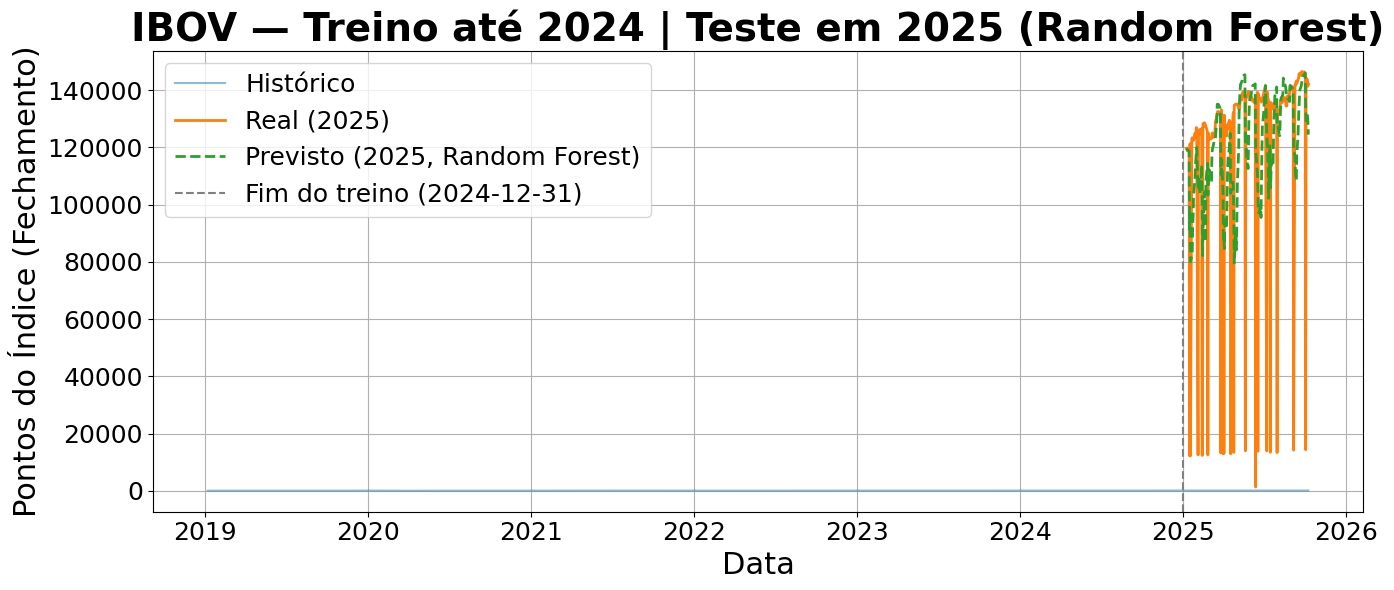

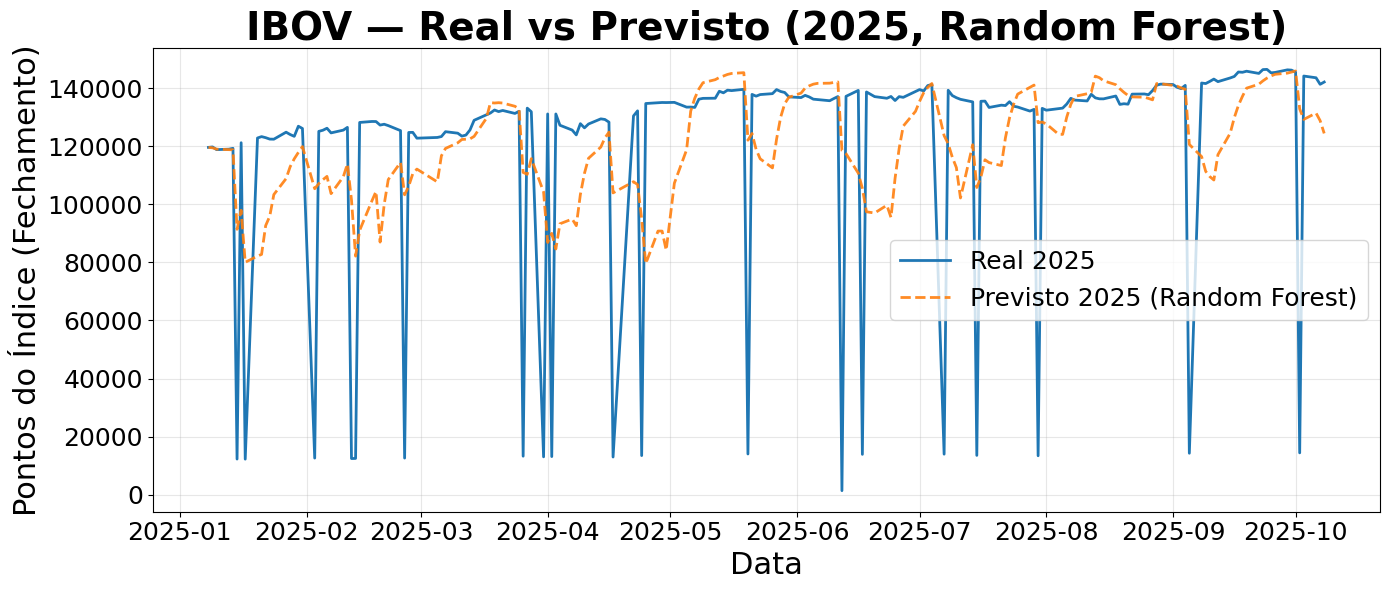

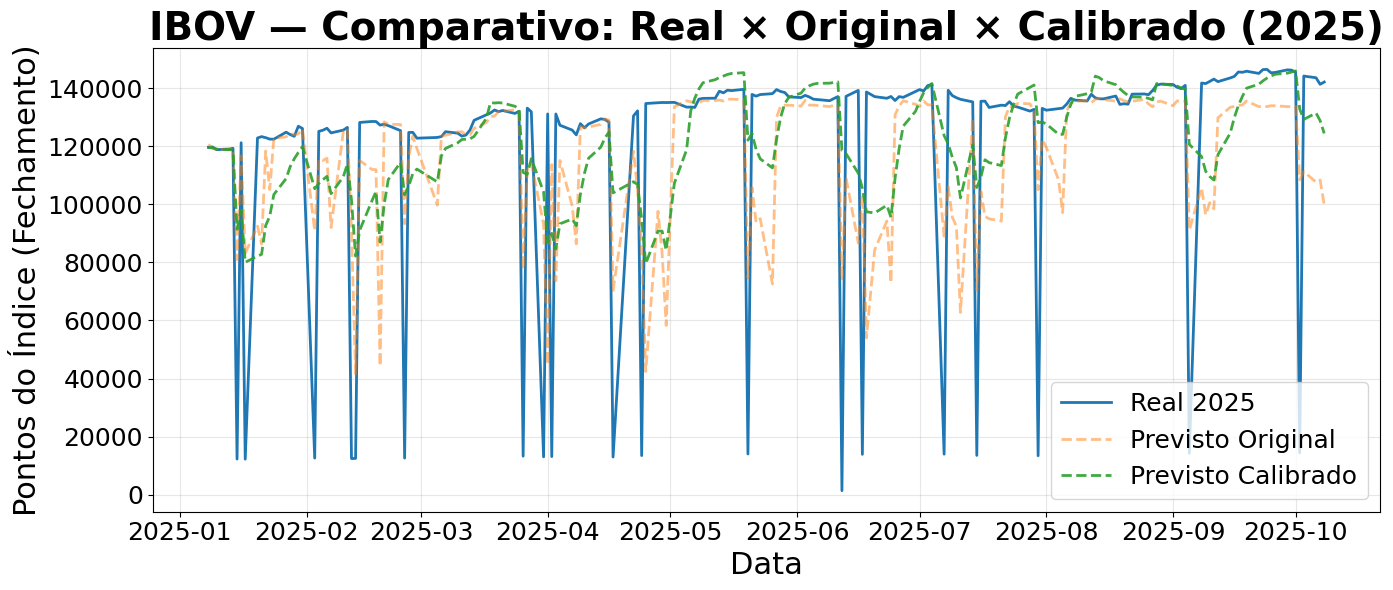

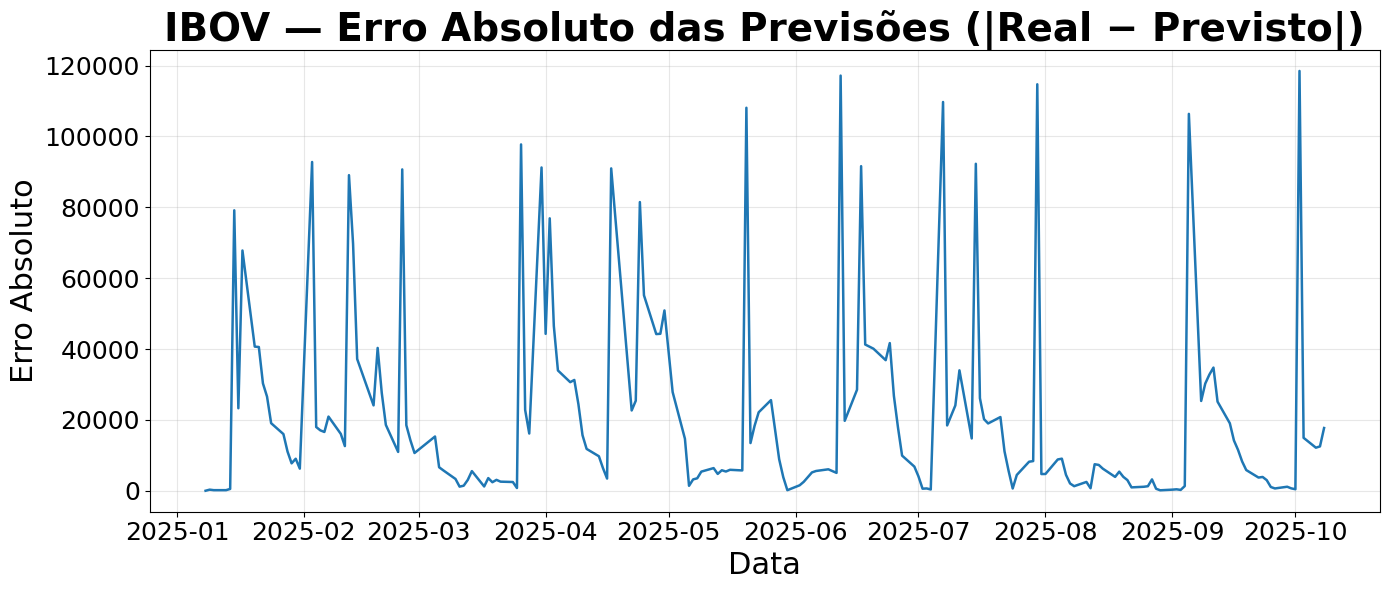


Arquivo 'Previsoes_IBOV_RF.csv' salvo com sucesso.


In [ ]:
# === Gráficos ===
train_end = pd.Timestamp('2024-12-31')

# Gráfico 1 — Histórico + Real vs Previsto (calibrado)
plt.figure(figsize=(14,6))
plt.plot(df['Data'], df['Último'], label='Histórico', alpha=0.5)
plt.plot(dates_test, y_test_real, label='Real (2025)', linewidth=2)
plt.plot(dates_test, y_pred_calibrated, label='Previsto (2025, Random Forest)', linewidth=2, linestyle='--')
plt.axvline(train_end, color='gray', linestyle='--', label='Fim do treino (2024-12-31)')

plt.title('IBOV — Treino até 2024 | Teste em 2025 (Random Forest)', fontsize=28, weight='bold')
plt.xlabel('Data', fontsize=22)
plt.ylabel('Pontos do Índice (Fechamento)', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()


# Gráfico 2 — Somente Real x Previsto (2025)
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test_real, label='Real 2025', linewidth=2)
plt.plot(dates_test, y_pred_calibrated, label='Previsto 2025 (Random Forest)', linewidth=2, linestyle='--', alpha=0.9)

plt.title('IBOV — Real vs Previsto (2025, Random Forest)', fontsize=28, weight='bold')
plt.xlabel('Data', fontsize=22)
plt.ylabel('Pontos do Índice (Fechamento)', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Gráfico 3 — Comparativo (Real vs Original vs Calibrado)
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test_real, label='Real 2025', linewidth=2)
plt.plot(dates_test, y_pred_raw, label='Previsto Original', linewidth=2, linestyle='--', alpha=0.5)
plt.plot(dates_test, y_pred_calibrated, label='Previsto Calibrado', linewidth=2, linestyle='--', alpha=0.9)

plt.title('IBOV — Comparativo: Real × Original × Calibrado (2025)', fontsize=28, weight='bold')
plt.xlabel('Data', fontsize=22)
plt.ylabel('Pontos do Índice (Fechamento)', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# === Gráfico do Erro Absoluto ===
plt.figure(figsize=(14,6))
plt.plot(dates_test, erro_absoluto, linewidth=1.8)

plt.title('IBOV — Erro Absoluto das Previsões (|Real − Previsto|)', fontsize=28, weight='bold')
plt.xlabel('Data', fontsize=22)
plt.ylabel('Erro Absoluto', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nArquivo 'Previsoes_IBOV_RF.csv' salvo com sucesso.")
